# Project Overview

This is a slightly modified approach to what we worked on in the first three weeks of the Capstone project. Here the list of neighboorhoods which was used for Toronto and New York is replaced by a postal zip codes. The latter was done as a surrogate for the neighborhood definition and allows unified and easy access to all US cities. In addition, the zip code database also includes the latitude and longitudes of the respective area.


# TO DO :
- Check NAN zip codes -> regenerate missing

Odd "outlier" values for lat,long of e.g. San Jose:

603	San Jose	California	62682	40.280	-89.630

604	San Jose	California	87565	35.500	-105.400

606	San Jose	California	95110	37.340	-121.910


- check unique longitutde , latitude values for zip codes
- get optimal value for "k" for KMEANS clustering
-> check DBX values

### Import libraries


In [23]:
!conda create --name myenv
#activate env
!activate myenv


Solving environment: done

## Package Plan ##

  environment location: /home/wsuser/.conda/envs/myenv



Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate myenv
#
# To deactivate an active environment, use
#
#     $ conda deactivate



In [29]:


!pip install bs4
from bs4 import BeautifulSoup

!pip install uszipcode
from uszipcode import SearchEngine

import numpy as np

import pandas as pd
import requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium # map rendering library

#!conda install -c conda-forge geopy --yes 
#!pip install goepy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


print ("Libraries imported")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

### Download list of most populated cities in US

In [30]:
# get list of most populous US cities from Wikipedia

url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
html = requests.get(url).text


### Extract table with BeautifulSoup

In [31]:

# get all tables with BeautifulSoup
soup = BeautifulSoup(html,"html5lib")

tables = soup.find_all("table")
table_index= -1
table = None

# find the correct table 
for i,table in enumerate(tables):
    if "New York City" in str(table) and "Chicago" in str(table): #
        table_index = i
        #break # first table which 

if table_index >=0:
    table = tables[table_index]
    print ("Table found")
    #print (table)
else:
    print ("No valid table found")
    table = None



Table found


### Extract required data from table and generate a pandas dataframe for cities with at least 1M inhabitants

In [32]:

table_contents=[]

# loop over all cells in the table 
for i,row in enumerate(table.findAll('tr')): # orig: td
    
    #create dictionary for a given cell to be added to dataframe

    if not i:
        #skip header
        continue

    arr = (row.text).split("\n")
    cell = {}

    if len(arr)>17:
        #city 
        cell['City'] = arr[3].split("[")[0]
        #state 
        cell['State'] = arr[5].replace("\xa0","")
        #print (arr)
        cell['Size Estimate'] = int(arr[7].replace(",",""))

        #print (cell)
        
        table_contents.append(cell)

#print(table_contents)
# print(table_contents)
cities = pd.DataFrame(table_contents)

cities.head(10)

,City,State,Size Estimate
0,New York City,New York,8336817
1,Los Angeles,California,3979576
2,Chicago,Illinois,2693976
3,Houston,Texas,2320268
4,Phoenix,Arizona,1680992
5,Philadelphia,Pennsylvania,1584064
6,San Antonio,Texas,1547253
7,San Diego,California,1423851
8,Dallas,Texas,1343573
9,San Jose,California,1021795


### Download zipcode database

In [33]:

#download zip code database
search = SearchEngine(simple_zipcode=True) # simple_zipcode=False


### Retrieve all zipcodes for cities with 1M or more inhabitants

In [34]:
#cities with at least one million inhabitants
tmpdata = []

for city, state,size in zip(cities["City"],cities["State"],cities["Size Estimate"]):
    if size > 1000000:
        #res = search.by_city_and_state(city, state)
        res = search.by_city(city=city, returns=0)
        if not len(res):
            print ("Error occurred for {}".format(city))
        else:
            #pcode = {}
            print ("Retrieved {} zip codes for {}".format(len(res),city))
            #city_zipcodes[city] = [z.zipcode for z in res]
            for z in res:
                pcode = {'City':city,'State':state,'Zipcode':z.zipcode,'Latitude':z.lat,'Longitude':z.lng}
                tmpdata.append(pcode)
        #break   # REMOVE ------------------------------
city_wzipcodes =  pd.DataFrame(tmpdata)
city_wzipcodes.head()

Retrieved 99 zip codes for New York City
Retrieved 64 zip codes for Los Angeles
Retrieved 58 zip codes for Chicago
Retrieved 106 zip codes for Houston
Retrieved 53 zip codes for Phoenix
Retrieved 56 zip codes for Philadelphia
Retrieved 68 zip codes for San Antonio
Retrieved 36 zip codes for San Diego
Retrieved 63 zip codes for Dallas
Retrieved 32 zip codes for San Jose


,City,State,Zipcode,Latitude,Longitude
0,New York City,New York,10001,40.750,-73.990
1,New York City,New York,10002,40.720,-73.990
2,New York City,New York,10003,40.730,-73.990
3,New York City,New York,10004,40.700,-74.020
4,New York City,New York,10005,40.705,-74.005


### Set up foursquare information

In [39]:
# The code was removed by Watson Studio for sharing.

### Function to retrieve location data from foursquare

In [40]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print (url) #REMOVE
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# TO DO --> SOME LATITUDE AND LONGITUDE VALUES ARE MISSING FROM ZIP CODE DATABASE



In [41]:
# TO DO --> SOME LATITUDE AND LONGITUDE VALUES ARE MISSING FROM ZIP CODE DATABASE


In [42]:

df = city_wzipcodes[city_wzipcodes["City"] == "San Jose"] # REDO REMOVE
df = df.dropna()
df.head(10000)




,City,State,Zipcode,Latitude,Longitude
603,San Jose,California,62682,40.280,-89.630
604,San Jose,California,87565,35.500,-105.400
606,San Jose,California,95110,37.340,-121.910
607,San Jose,California,95111,37.280,-121.830
608,San Jose,California,95112,37.340,-121.880
609,San Jose,California,95113,37.334,-121.891
610,San Jose,California,95116,37.350,-121.850
611,San Jose,California,95117,37.310,-121.970
612,San Jose,California,95118,37.260,-121.890
613,San Jose,California,95119,37.230,-121.790


In [43]:

df_venues = getNearbyVenues(df["Zipcode"],df["Latitude"] , df["Longitude"], radius=500)

df_venues.head()

,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,95110,37.34,-121.91,Trader Joe's,37.340948,-121.909405,Grocery Store
1,95110,37.34,-121.91,PetSmart,37.339942,-121.907791,Pet Store
2,95110,37.34,-121.91,Blaze Pizza,37.341754,-121.911114,Pizza Place
3,95110,37.34,-121.91,Tacomania (Taco Truck),37.342056,-121.910236,Taco Place
4,95110,37.34,-121.91,Sultan Bakery,37.340354,-121.912812,Bakery


### One hot encoding of venue information:


In [44]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
df_onehot['Zipcode'] = df_venues['Zipcode'] 

# move ipcode column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()


,Zipcode,ATM,American Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,95110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,95110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,95110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,95110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### group rows by zip code and by taking the mean of the frequency of occurrence of each category


In [45]:
df_grouped = df_onehot.groupby('Zipcode').mean().reset_index()
df_grouped.head()


,Zipcode,ATM,American Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,95110,0.0,0.000000,0.00,0.00,0.0,0.022222,0.00000,0.0,0.000000,...,0.022222,0.00,0.022222,0.0,0.000000,0.022222,0.000000,0.000000,0.00,0.00
1,95111,0.0,0.000000,0.00,0.00,0.0,0.000000,0.00000,0.0,0.055556,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.055556,0.055556,0.00,0.00
2,95112,0.0,0.047619,0.00,0.00,0.0,0.000000,0.02381,0.0,0.000000,...,0.023810,0.00,0.000000,0.0,0.047619,0.000000,0.000000,0.119048,0.00,0.00
3,95113,0.0,0.010000,0.01,0.01,0.0,0.000000,0.02000,0.0,0.000000,...,0.000000,0.02,0.000000,0.0,0.010000,0.000000,0.000000,0.000000,0.01,0.01
4,95116,0.0,0.000000,0.00,0.00,0.0,0.000000,0.00000,0.0,0.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00


In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### top 10 venues for each neighborhood.


In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['Zipcode'] = df_grouped['Zipcode']

for ind in np.arange(df_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()


,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,95110,Garden,Coffee Shop,Bank,Playground,Pizza Place,Fast Food Restaurant,Health & Beauty Service,Burger Joint,Convenience Store,Sandwich Place
1,95111,Convenience Store,Mexican Restaurant,Café,Chinese Restaurant,Fried Chicken Joint,Automotive Shop,Sandwich Place,Speakeasy,Bus Station,Seafood Restaurant
2,95112,Vietnamese Restaurant,Sandwich Place,Convenience Store,American Restaurant,Vegetarian / Vegan Restaurant,Grocery Store,Coffee Shop,Café,Pizza Place,Juice Bar
3,95113,Mexican Restaurant,Cocktail Bar,Restaurant,Hotel,Ice Cream Shop,Café,Pub,Sandwich Place,Coffee Shop,Bar
4,95116,Mexican Restaurant,Fried Chicken Joint,Golf Course,Yoga Studio,Dive Bar,Discount Store,Diner,Dessert Shop,Department Store,Deli / Bodega


### cluster neighborhoods


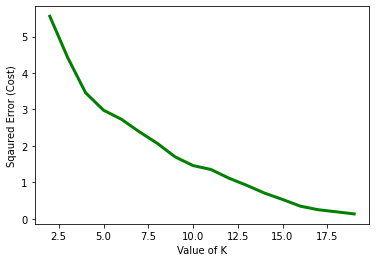

array([ 0, 18,  0,  0, 10,  6, 12,  4,  3,  8], dtype=int32)

In [73]:
import matplotlib.pyplot as plt 

# set number of clusters
cost =[]
k_values = [i for i in range(2,20)]

df_grouped_clustering = df_grouped.drop('Zipcode', 1)
#print (toronto_grouped_clustering.head())
# run k-means clustering
for kclusters in k_values:
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
    #print (dir(kmeans))
    #print (kmeans.inertia_)
    cost.append(kmeans.inertia_)
    
# plot the cost against K values
plt.plot(k_values, cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

### re-cluster with appropriate "k"-value

In [74]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df_grouped_clustering)

### create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [75]:
# add clustering labels
zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_merged = df

# merge df_grouped with df_data to add latitude/longitude for each zipcode
df_merged = df_merged.join(zipcodes_venues_sorted.set_index('Zipcode'), on='Zipcode')

# DBX -> FIX
df_merged = df_merged.dropna()

df_merged.head(20) # check the last columns!

,City,State,Zipcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
606,San Jose,California,95110,37.340,-121.910,1.0,Garden,Coffee Shop,Bank,Playground,Pizza Place,Fast Food Restaurant,Health & Beauty Service,Burger Joint,Convenience Store,Sandwich Place
607,San Jose,California,95111,37.280,-121.830,1.0,Convenience Store,Mexican Restaurant,Café,Chinese Restaurant,Fried Chicken Joint,Automotive Shop,Sandwich Place,Speakeasy,Bus Station,Seafood Restaurant
608,San Jose,California,95112,37.340,-121.880,1.0,Vietnamese Restaurant,Sandwich Place,Convenience Store,American Restaurant,Vegetarian / Vegan Restaurant,Grocery Store,Coffee Shop,Café,Pizza Place,Juice Bar
609,San Jose,California,95113,37.334,-121.891,1.0,Mexican Restaurant,Cocktail Bar,Restaurant,Hotel,Ice Cream Shop,Café,Pub,Sandwich Place,Coffee Shop,Bar
610,San Jose,California,95116,37.350,-121.850,0.0,Mexican Restaurant,Fried Chicken Joint,Golf Course,Yoga Studio,Dive Bar,Discount Store,Diner,Dessert Shop,Department Store,Deli / Bodega
611,San Jose,California,95117,37.310,-121.970,6.0,Convenience Store,Liquor Store,Yoga Studio,Department Store,Ethiopian Restaurant,Doctor's Office,Dive Bar,Discount Store,Diner,Dessert Shop
612,San Jose,California,95118,37.260,-121.890,1.0,Convenience Store,Indian Restaurant,Video Store,Pizza Place,Intersection,Dance Studio,Doctor's Office,Dive Bar,Discount Store,Diner
613,San Jose,California,95119,37.230,-121.790,5.0,Construction & Landscaping,Grocery Store,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Doctor's Office,Dive Bar,Discount Store,Diner,Dessert Shop
614,San Jose,California,95120,37.170,-121.840,4.0,Trail,Yoga Studio,Deli / Bodega,Ethiopian Restaurant,Doctor's Office,Dive Bar,Discount Store,Diner,Dessert Shop,Department Store
615,San Jose,California,95121,37.300,-121.810,8.0,Intersection,Playground,BBQ Joint,Spa,Convenience Store,Construction & Landscaping,Ethiopian Restaurant,Doctor's Office,Dive Bar,Discount Store


### display cluster information of zip codes on map


In [84]:
# create map
address = 'San Jose, California'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Zipcode'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[(int(cluster))-1],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters